In [1]:
import os
import time

# Ignore Warnings
import warnings

#data Manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

%matplotlib inline

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Feature Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# Models/Algorithms
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Metrics
import math
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm

import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')  # Disabling warning outputs

In [2]:
### Load data

save_directory = os.path.join('processed_data')

try:
    X_train = pd.read_csv(os.path.join(save_directory, 'X_train.csv'))
    X_test = pd.read_csv(os.path.join(save_directory, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(save_directory, 'y_train.csv')) #.squeeze() # .squeeze() to convert back to Series
    y_test = pd.read_csv(os.path.join(save_directory, 'y_test.csv'))# .squeeze()
    
    print(f"Loaded X_train shape: {X_train.shape}")
    print(f"Loaded y_train shape: {y_train.shape}")
    print("Data loaded successfully!")
except Exception as e:
    print(f"An error occurred while loading: {e}")

Loaded X_train shape: (1037340, 7)
Loaded y_train shape: (1037340, 1)
Data loaded successfully!


In [3]:
def map_genders(df):
    gender_mapping = {'M': 0, 'F': 1} # Or you could use {'M': 1, 'F': 0}

    # Apply the mapping directly to the 'gender' column in both training and testing sets
    df['gender'] = df['gender'].map(gender_mapping)
    return df

In [4]:
def fit_and_save_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[[column]])
    joblib.dump(ohe, encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)


In [5]:
X_train = map_genders(X_train)
X_train = fit_and_save_ohe(X_train)
X_train.shape

(1037340, 20)

In [6]:
def load_and_transform_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = joblib.load(encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)

In [7]:
X_test = map_genders(X_test)
X_test = load_and_transform_ohe(X_test)
X_test.shape

(259335, 20)

# <a id='sixth'></a> Model Training

In [8]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [9]:
##Global variables
batch_size = 32
epochs = 5

In [10]:
# 1. Convert NumPy arrays to tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)#.unsqueeze(1)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)#.unsqueeze(1)

# 2. Create DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [11]:
# 3. Define Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [12]:
# 4. Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# 5. Train the Model
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

print("\nModel training complete.")
end_time = time.time()

print(f"Training duration: {(end_time - start_time) / 60:.2f} minutes")

Epoch 1/5, Loss: 1097.9395
Epoch 2/5, Loss: 915.5613
Epoch 3/5, Loss: 892.7723
Epoch 4/5, Loss: 879.3721
Epoch 5/5, Loss: 861.6319

Model training complete.
Training duration: 13.32 minutes


In [14]:
# 6. Evaluate on Test Set
print("\n--- Making Predictions (PyTorch) ---")
try:
    model.eval()  # Set model to evaluation mode
    
    # Predict probabilities for the positive class (fraud) for training set
    y_train_pred_proba_list = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_train_pred_proba_list.extend(outputs.cpu().numpy())
    y_train_pred_proba = np.array(y_train_pred_proba_list).flatten()

    # Predict probabilities for the positive class (fraud) for test set
    y_test_pred_proba_list = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_test_pred_proba_list.extend(outputs.cpu().numpy())
    y_test_pred_proba = np.array(y_test_pred_proba_list).flatten()

    # Convert probabilities to binary predictions using a 0.5 threshold
    y_train_pred_binary = (y_train_pred_proba > 0.5).astype(int)
    y_test_pred_binary = (y_test_pred_proba > 0.5).astype(int)

    # Use your print_score function
    # Note: For print_score, y_train and y_test should be the original NumPy arrays
    # or the corresponding y_train_tensor.cpu().numpy()
    print_score(y_train_tensor.cpu().numpy().flatten(), y_train_pred_binary, train=True) # Use probabilities for ROC AUC
    print_score(y_test_tensor.cpu().numpy().flatten(), y_test_pred_binary, train=False) # Use probabilities for ROC AUC

except NameError:
    print("Skipping predictions: Model or data (tensors/loaders) not found. Please provide them.")
except Exception as e:
    print(f"An error occurred during PyTorch predictions: {e}")


--- Making Predictions (PyTorch) ---
Train Result:
Accuracy Score: 99.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision  9.942070e-01     0.004050   0.99185  4.991286e-01  9.884751e-01
recall     9.976157e-01     0.001665   0.99185  4.996405e-01  9.918503e-01
f1-score   9.959084e-01     0.002360   0.99185  4.991343e-01  9.901569e-01
support    1.031335e+06  6005.000000   0.99185  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1028876    2459]
 [   5995      10]]

Test Result:
Accuracy Score: 99.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0          1.0  accuracy      macro avg   weighted avg
precision       0.994207     0.003534  0.992045       0.498870       0.988473
recall          0.997813     0.001332  0.992045       0.499572       0.992045
f1-score        0.996007     0

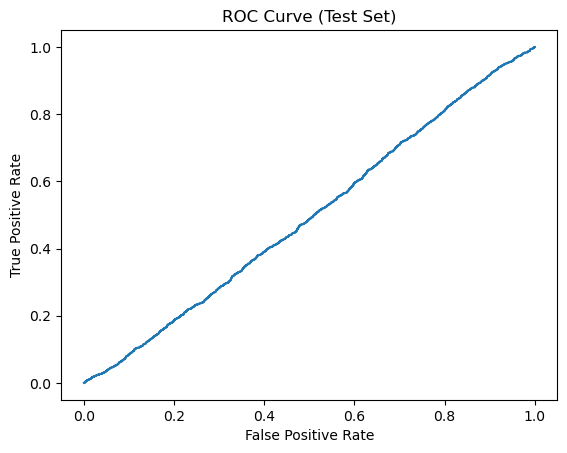

In [15]:
# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve (Test Set)")
plt.show()

In [16]:
# 8. Save Model (Optional)
torch.save(model.state_dict(), "artifacts/pytorach_model.pth")

In [17]:
def scale_and_save_scaler(X_train_data, scaler_filepath='artifacts/scaler.pkl'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_data)
    joblib.dump(scaler, scaler_filepath)
    return X_train_scaled

# --- Part 2: Load Scaler and Transform X_test ---

def load_scaler_and_transform_X_test(X_test_data, scaler_filepath='artifacts/scaler.pkl'):
    loaded_scaler = joblib.load(scaler_filepath)
    X_test_scaled = loaded_scaler.transform(X_test_data)
    return X_test_scaled

In [18]:
###This time X_train and X_test are scalled

X_train = scale_and_save_scaler(X_train)
X_test = scale_and_save_scaler(X_test)

# 1. Convert NumPy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)#.unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)#.unsqueeze(1)

# 2. Create DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [19]:
# 5. Train the Model
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

print("\nModel training complete.")
end_time = time.time()

print(f"Training duration: {(end_time - start_time) / 60:.2f} minutes")

Epoch 1/5, Loss: 558.0937
Epoch 2/5, Loss: 431.3685
Epoch 3/5, Loss: 407.4391
Epoch 4/5, Loss: 390.2255
Epoch 5/5, Loss: 378.4234

Model training complete.
Training duration: 12.37 minutes


In [20]:
# 6. Evaluate on Test Set
print("\n--- Making Predictions (PyTorch) ---")
try:
    model.eval()  # Set model to evaluation mode
    
    # Predict probabilities for the positive class (fraud) for training set
    y_train_pred_proba_list = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_train_pred_proba_list.extend(outputs.cpu().numpy())
    y_train_pred_proba = np.array(y_train_pred_proba_list).flatten()

    # Predict probabilities for the positive class (fraud) for test set
    y_test_pred_proba_list = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_test_pred_proba_list.extend(outputs.cpu().numpy())
    y_test_pred_proba = np.array(y_test_pred_proba_list).flatten()

    # Convert probabilities to binary predictions using a 0.5 threshold
    y_train_pred_binary = (y_train_pred_proba > 0.5).astype(int)
    y_test_pred_binary = (y_test_pred_proba > 0.5).astype(int)

    # Use your print_score function
    # Note: For print_score, y_train and y_test should be the original NumPy arrays
    # or the corresponding y_train_tensor.cpu().numpy()
    print_score(y_train_tensor.cpu().numpy().flatten(), y_train_pred_binary, train=True) # Use probabilities for ROC AUC
    print_score(y_test_tensor.cpu().numpy().flatten(), y_test_pred_binary, train=False) # Use probabilities for ROC AUC

except NameError:
    print("Skipping predictions: Model or data (tensors/loaders) not found. Please provide them.")
except Exception as e:
    print(f"An error occurred during PyTorch predictions: {e}")



--- Making Predictions (PyTorch) ---
Train Result:
Accuracy Score: 98.94%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision  9.942188e-01     0.007350   0.98943  5.007844e-01  9.885059e-01
recall     9.951548e-01     0.006162   0.98943  5.006582e-01  9.894297e-01
f1-score   9.946866e-01     0.006704   0.98943  5.006950e-01  9.889673e-01
support    1.031335e+06  6005.000000   0.98943  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1026338    4997]
 [   5968      37]]

Test Result:
Accuracy Score: 98.98%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0          1.0  accuracy      macro avg   weighted avg
precision       0.994206     0.004378  0.989847       0.499292       0.988477
recall          0.995590     0.003331  0.989847       0.499461       0.989847
f1-score        0.994898     0

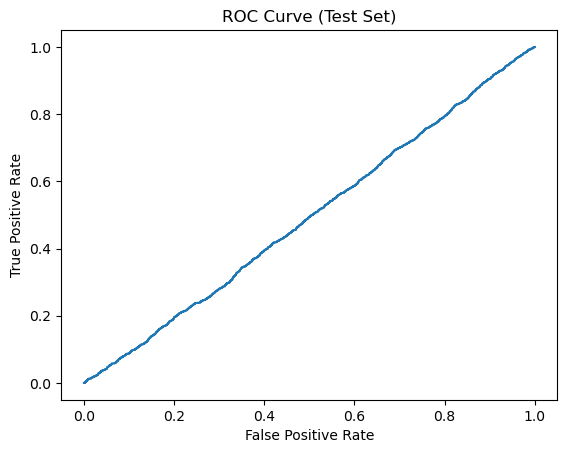

In [21]:
# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve (Test Set)")
plt.show()